In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
# 1. Load data
X, y = fetch_covtype(return_X_y=True, as_frame=False)

In [3]:
# 2. Filter out classes 1 and 2
mask = ~np.isin(y, [1, 2])
X_filt = X[mask]
y_filt = y[mask]

print("After filtering:", np.bincount(y_filt).astype(int))

After filtering: [    0     0     0 35754  2747  9493 17367 20510]


In [4]:
# 3. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_filt, y_filt,
    test_size=0.2,
    stratify=y_filt,
    random_state=42
)

In [5]:
# 4. Set up GridSearchCV
param_grid = {
    'n_neighbors': list(range(1, 16, 2)),      # odd k from 1 to 15
    'weights': ['uniform', 'distance']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier()

grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best parameters found:", grid.best_params_)
print(f"Best CV accuracy: {grid.best_score_:.4f}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'n_neighbors': 1, 'weights': 'uniform'}
Best CV accuracy: 0.9729


In [6]:
# 5. Evaluate on held-out test set
best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision (weighted)': precision_score(y_test, y_pred, average='weighted'),
    'Recall (weighted)': recall_score(y_test, y_pred, average='weighted'),
    'F1-score (weighted)': f1_score(y_test, y_pred, average='weighted')
}

print("\nTest-set performance:")
print(classification_report(y_test, y_pred, digits=4))



Test-set performance:
              precision    recall  f1-score   support

           3     0.9750    0.9775    0.9763      7151
           4     0.8944    0.8798    0.8871       549
           5     0.9853    0.9889    0.9871      1899
           6     0.9627    0.9583    0.9605      3474
           7     0.9998    0.9998    0.9998      4102

    accuracy                         0.9771     17175
   macro avg     0.9634    0.9608    0.9621     17175
weighted avg     0.9770    0.9771    0.9770     17175



{'Accuracy': 0.9770596797671034, 'Precision (weighted)': 0.9770017695149167, 'Recall (weighted)': 0.9770596797671034, 'F1-score (weighted)': 0.9770267412113356}


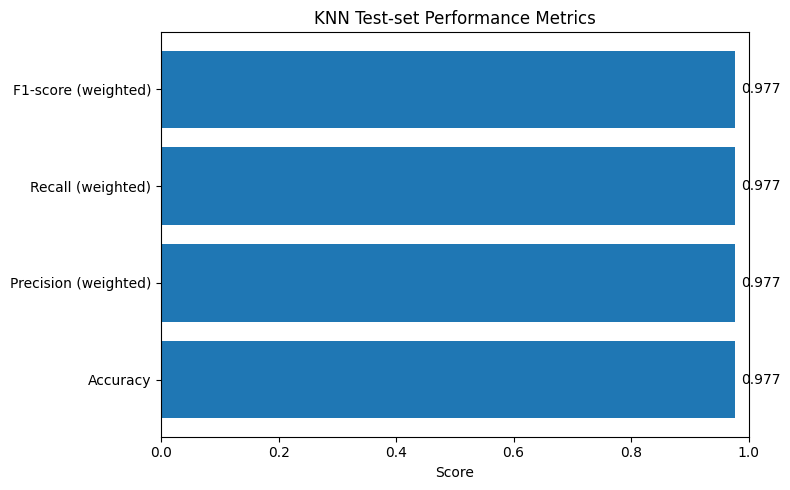

In [7]:
print(metrics)
# 6. Visualize metrics
plt.figure(figsize=(8,5))
names = list(metrics.keys())
values = list(metrics.values())
bars = plt.barh(names, values)
plt.xlim(0, 1.0)
plt.xlabel('Score')
plt.title('KNN Test-set Performance Metrics')
for bar, val in zip(bars, values):
    plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
             f"{val:.3f}", va='center')
plt.tight_layout()
plt.show()